<a href="https://colab.research.google.com/github/ranaehelal/Fashon_Mnist/blob/oooppss/FashionMnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### import libraries

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from sklearn.datasets import make_blobs



In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,Input

### load data

In [5]:
data = tf.keras.datasets.fashion_mnist.load_data()
(train_images,train_label),(test_images,test_labels)=data

#### training set of 60,000 examples and a test set of 10,000 examples.

In [ ]:
print (test_images.shape)
print (test_labels.shape)


(10000, 28, 28)
(10000,)


In [ ]:
print (train_images.shape)
print (train_label.shape)

(60000, 28, 28)
(60000,)


In [ ]:
print (train_label[:100])

[9 0 0 3 0 2 7 2 5 5 0 9 5 5 7 9 1 0 6 4 3 1 4 8 4 3 0 2 4 4 5 3 6 6 0 8 5
 2 1 6 6 7 9 5 9 2 7 3 0 3 3 3 7 2 2 6 6 8 3 3 5 0 5 5 0 2 0 0 4 1 3 1 6 3
 1 4 4 6 1 9 1 3 5 7 9 7 1 7 9 9 9 3 2 9 3 6 4 1 1 8]


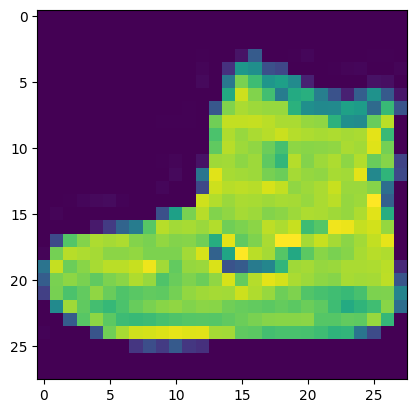

In [ ]:
plt.imshow(train_images[0])

### Visualize sample images and their labels


In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


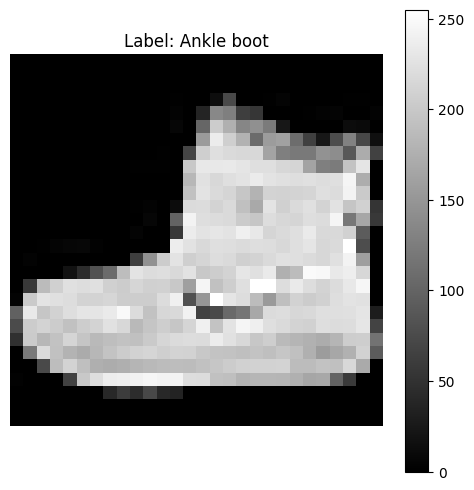

In [ ]:
def plot_image(image, label):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {class_names[label]}")
    plt.colorbar()
    plt.axis('off')
    plt.show()

plot_image(train_images[0], train_label[0])


### Visualize 25 Sample Images  
A function to display a 5x5 grid of images with labels.


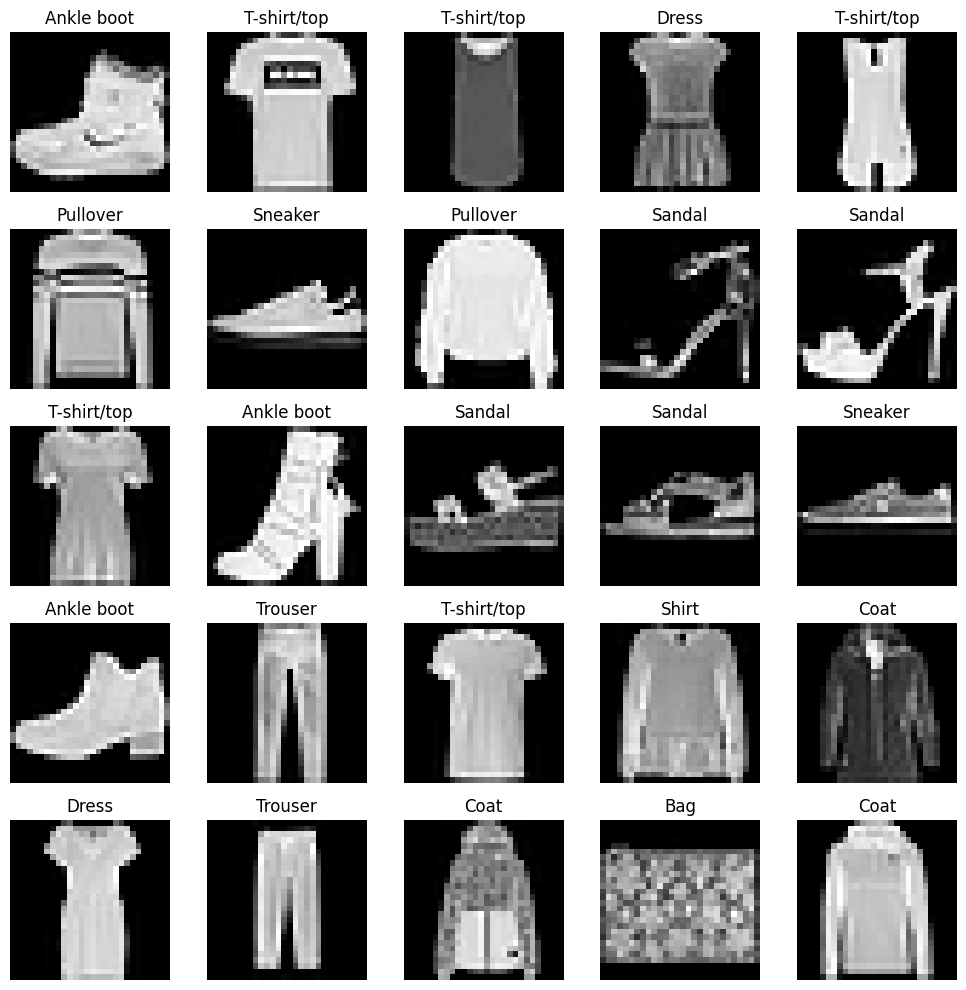

In [ ]:
def plot_sample_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()
plot_sample_images(train_images, train_label, class_names)


### Visualize Images by Label


In [ ]:
def plot_label(images, labels, label, filter_function=None):
    # Get indices of images with the specified label
    label_indices = np.argwhere(labels == label).flatten()
    num_images = min(len(label_indices), 10)  # Limit to 10 images

    plt.figure(figsize=(14, 8))

    for i in range(num_images):
        img_idx = label_indices[i]
        sample_img = images[img_idx]

        if filter_function:
            sample_img = filter_function(sample_img)

        plt.subplot(1, 10, i + 1)
        plt.title(class_names[label])
        plt.imshow(sample_img, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


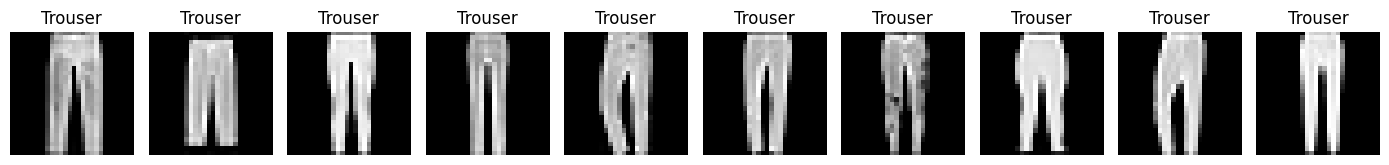

In [ ]:
# Visualizing images with label 1 (Trouser)
plot_label(train_images, train_label, label=1)


### Data Preprocessing and Splitting

In this section, we preprocess the dataset by normalizing the image pixel values. Each pixel value is scaled to a float between 0 and 1 by dividing by 255.0. This ensures the values are within the range the model expects and helps with convergence during training.

Next, we define a function `train_validate_test_split` to split the dataset into training, validation, and test sets. The function accepts the dataset and labels as inputs, along with optional parameters to specify the ratio for the test and validation sets. We use this function to create the training, validation, and test sets, ensuring reproducibility with a fixed random seed.

Finally, the shapes of the resulting datasets are printed to verify the splits.


In [6]:
train_images=train_images.astype('float32')/255.0
test_images=test_images.astype('float32')/255.0

In [ ]:
train_images[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

In [7]:
def train_validate_test_split(data, labels, test_ratio=0.3, val_ratio=0.3, random_seed=None):
    if test_ratio + val_ratio > 1:
        raise ValueError("The sum of test_ratio and val_ratio must be <= 1.")

    # Set random seed for reproducibility
    if random_seed is not None:
        np.random.seed(random_seed)

    # Calculate sizes of each set
    test_set_size = int(len(data) * test_ratio)
    val_set_size = int(len(data) * val_ratio)
    indices = np.random.permutation(len(data))  # shuffle indices

    test_indices = indices[:test_set_size]  # test set
    val_indices = indices[test_set_size:test_set_size + val_set_size]  # validation set
    train_indices = indices[test_set_size + val_set_size:]  # training set

    # Split data and labels based on indices
    X_train, X_val, X_test = data[train_indices], data[val_indices], data[test_indices]
    y_train, y_val, y_test = labels[train_indices], labels[val_indices], labels[test_indices]

    return X_train, X_val, X_test, y_train, y_val, y_test


X_train, X_val, X_test, y_train, y_val, y_test = train_validate_test_split(train_images, train_label, test_ratio=0.2,
                                                                           val_ratio=0.2, random_seed=42)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(36000, 28, 28) (36000,)
(12000, 28, 28) (12000,)
(12000, 28, 28) (12000,)


### Plot Histograms for Label Distribution
In this section, we'll visualize the distribution of labels for the training, validation, and test datasets using histograms. Each histogram will show the frequency of each class in the respective dataset.

The histograms will help us understand the distribution and class balance of the dataset.


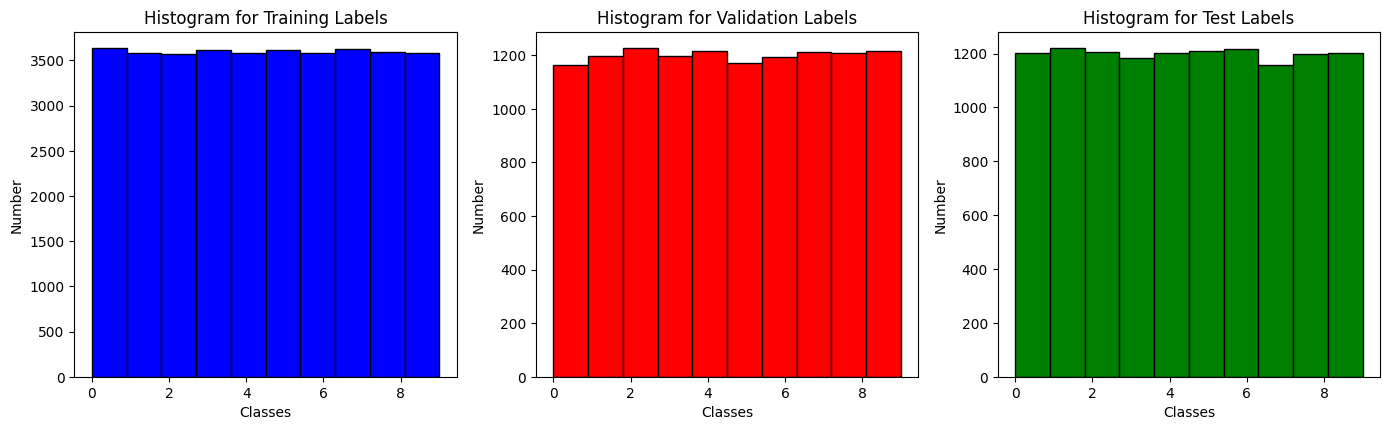

In [ ]:

def plot_label_histogram(y_train, y_val, y_test):

    plt.figure(figsize=(14, 8))

    # Histogram for training labels
    plt.subplot(2, 3, 1)
    plt.hist(y_train, range=(0, 9), bins=10, color='blue', edgecolor='black')
    plt.xlabel('Classes')
    plt.ylabel('Number')
    plt.title('Histogram for Training Labels')

    # Histogram for validation labels
    plt.subplot(2, 3, 2)
    plt.hist(y_val, range=(0, 9), bins=10, color='red', edgecolor='black')
    plt.xlabel('Classes')
    plt.ylabel('Number')
    plt.title('Histogram for Validation Labels')

    # Histogram for test labels
    plt.subplot(2, 3, 3)
    plt.hist(y_test, range=(0, 9), bins=10, color='green', edgecolor='black')
    plt.xlabel('Classes')
    plt.ylabel('Number')
    plt.title('Histogram for Test Labels')

    plt.tight_layout()
    plt.show()

# Example usage:
plot_label_histogram(y_train, y_val, y_test)


### Model Architecture and Training

In this section, we define a simple feedforward neural network using Keras' Sequential API for classifying the Fashion MNIST dataset. The model consists of:
- An input layer with shape `(28, 28)` to accept the images.
- A Flatten layer to convert the 2D image data into a 1D vector.
- A Dense layer with 128 units and ReLU activation for the hidden layer.
- An output layer with 10 units and softmax activation to predict one of the 10 classes.

We then compile the model with the Adam optimizer and sparse categorical cross-entropy loss. The model is trained for 10 epochs with a batch size of 32, and we validate it on a validation set.

Finally, we evaluate the model's performance on the test set.


In [ ]:

model = Sequential()

model.add(Input(shape=(28, 28)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))  # Fully connected layer with 128 units
model.add(Dense(10, activation='softmax'))  # Output layer with 10 units (for 10 classes)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7577 - loss: 0.6990 - val_accuracy: 0.8465 - val_loss: 0.4369
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8533 - loss: 0.4075 - val_accuracy: 0.8696 - val_loss: 0.3745
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8716 - loss: 0.3546 - val_accuracy: 0.8718 - val_loss: 0.3578
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8766 - loss: 0.3339 - val_accuracy: 0.8764 - val_loss: 0.3375
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8885 - loss: 0.3054 - val_accuracy: 0.8775 - val_loss: 0.3351
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8942 - loss: 0.2942 - val_accuracy: 0.8817 - val_loss: 0.3334
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8978 - loss: 0.2769 - val_accuracy: 0.8779 - val_loss: 0.3403
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9006 - loss: 0.2662 - 

In [ ]:
test_loss ,test_acc=model.evaluate(X_test, y_test)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8797 - loss: 0.3441


In [9]:
from sklearn.metrics import confusion_matrix

def calculate_metrics(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # TP, FN, FP, TN
    TN, FP, FN, TP = cm.ravel()

    # Accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    # Precision
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0

    # Recall
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0

    # F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    return accuracy, precision, recall, f1_score




In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

def calculate_metrics_built_in(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)

    # Calculate precision, recall, and F1 score for multi-class
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Print confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    return accuracy, precision, recall, f1



In [21]:
models_results = {
    "Neural Network (NN)": {
        "Accuracy": 87.72,
        "Precision": 88.06,
        "Recall": 87.72,
        "F1 Score": 87.56
    },
    "Naive Bayes (NBC)": {
        "Accuracy": 58.32,
        "Precision": 63.85,
        "Recall": 58.32,
        "F1 Score": 55.29
    },
    "Support Vector Machine (SVM)": {
        "Accuracy": 84.70,
        "Precision": 84.69,
        "Recall":  84.70,
        "F1 Score": 84.63
    },
    "K-Nearest Neighbors (KNN)": {
        "Accuracy": 84.79,
        "Precision": 85.06,
        "Recall": 84.79,
        "F1 Score": 84.67
    },
    "One-vs-Rest Hard Margin SVM": {
        "Accuracy": 42.5,
        "Precision": 86.36,
        "Recall": 67.86,
        "F1 Score": 76.0
    },
    "One-vs-Rest Soft Margin SVM": {
        "Accuracy": 94.17,
        "Precision": 89.29,
        "Recall": 89.29,
        "F1 Score": 89.29
    }
}

### **Phase 2: Implementing Hard Margin SVM from Scratch**

- implement a **Hard Margin Support Vector Machine (SVM)** from scratch.


## Hard Margin SVM works on a binary classification task.


### Step 1: Implement Hard Margin SVM


In [ ]:
def solve_svm_hard_margin(X, y):
    X = np.atleast_2d(X)
    y = y.astype(float).reshape(-1, 1)
    n_samples, n_features = X.shape

    # Kernel: Linear kernel (dot product)
    K = np.dot(X, X.T)

    # Setup the objective function (P, q)
    P = np.outer(y, y) * K  # (n_samples, n_samples)
    q = -np.ones((n_samples, 1))  # (n_samples, 1)

    # Setup the constraints (A, b)
    A = matrix(y.T, (1, n_samples))  # (1, n_samples)
    b = matrix(1.0)  # All constraints should equal 1

    # Setup the inequality constraints (alpha_i >= 0)
    G = matrix(-np.eye(n_samples))  # For alpha_i >= 0
    h = matrix(np.zeros(n_samples))  # (n_samples, 1)

    # Solve the QP problem using cvxopt
    solution = solvers.qp(matrix(P), matrix(q), matrix(G), matrix(h), matrix(A), matrix(b))
    alphas = np.ravel(solution['x'])

    return alphas


### Step 2: Extract weights and bias for Hard Margin SVM.


In [ ]:
def extract_weights_and_bias(X, y, alphas):
    support_vectors = np.where(alphas > 1e-5)[0]  # Indices of support vectors
    alphas_sv = alphas[support_vectors]
    X_sv = X[support_vectors]
    y_sv = y[support_vectors]

    # Calculate weights (w)
    w = np.sum(alphas_sv[:, np.newaxis] * y_sv[:, np.newaxis] * X_sv, axis=0)

    # Calculate bias (b)
    b = np.mean(y_sv - np.dot(X_sv, w))

    return w, b, support_vectors, y_sv


### Step 3: Predict with Hard Margin SVM

In [ ]:
def predict(X, w, b):
    return np.sign(np.dot(X, w) + b)


### Step 4:One-vs-Rest SVM for Multiclass Classification



In [ ]:
def one_vs_rest_svm_hard_margin(X_train, y_train, X_test, y_test, num_classes=10):
    alphas_all = []
    ws = []
    bs = []

    # Train a binary SVM for each class (One-vs-Rest)
    for class_label in range(num_classes):
        # Create binary labels (1 for the current class, -1 for all others)
        binary_y_train = np.where(y_train == class_label, 1, -1)

        # Solve the SVM optimization problem for the current class
        alphas = solve_svm_hard_margin(X_train, binary_y_train)

        # Extract weights and bias for the current class
        w, b, _, _ = extract_weights_and_bias(X_train, binary_y_train, alphas)

        # Save the weights and bias
        ws.append(w)
        bs.append(b)

    # Now predict for the test set
    y_pred = np.zeros(X_test.shape[0])

    for i in range(X_test.shape[0]):
        # Predict using the class with the maximum decision value
        decision_values = [np.dot(X_test[i], w) + b for w, b in zip(ws, bs)]
        y_pred[i] = np.argmax(decision_values)  # Choose the class with the highest decision value

  # Calculate accuracy, precision, recall, and F1 score
    accuracy, precision, recall, f1_score = calculate_metrics(y_test, y_pred)
    return accuracy, precision, recall, f1_score


### Step 5: Evaluating Model Performance

In [ ]:
accuracy, precision, recall, f1_score = one_vs_rest_svm_hard_margin(X_train, y_train, X_test, y_test, num_classes=10)

print(f"One-vs-Rest Hard Margin SVM Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1_score * 100:.2f}%")

     pcost       dcost       gap    pres   dres
 0: -7.6468e+01 -1.5453e+02  3e+03  5e+01  2e+00
 1: -9.9508e+01 -8.4364e+01  1e+03  2e+01  9e-01
 2: -4.2295e+01 -6.0633e+00  3e+02  4e+00  2e-01
 3: -3.7887e+00  1.5112e+00  3e+01  5e-01  2e-02
 4: -3.4965e-01  2.2232e+00  1e+01  2e-01  8e-03
 5:  5.8499e-01  2.8660e+00  1e+01  1e-01  4e-03
 6:  1.2028e+00  3.6955e+00  6e+00  6e-02  2e-03
 7:  2.4644e+00  5.2754e+00  4e+00  3e-02  1e-03
 8:  4.2136e+00  6.1554e+00  2e+00  1e-02  5e-04
 9:  6.3759e+00  6.4397e+00  1e-01  4e-04  2e-05
10:  6.4411e+00  6.4419e+00  1e-03  5e-06  2e-07
11:  6.4419e+00  6.4419e+00  1e-05  5e-08  2e-09
12:  6.4419e+00  6.4419e+00  1e-07  5e-10  2e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.4583e+02 -3.5050e+02  4e+03  5e+01  2e+00
 1: -2.9922e+02 -4.1571e+02  3e+03  3e+01  1e+00
 2: -5.2455e+02 -4.5606e+02  2e+03  2e+01  9e-01
 3: -7.3835e+02 -4.7107e+02  2e+03  1e+01  6e-01
 4: -5.4018e+02 -2.1786e+02  1e+03  8e+00  4e-0

## Soft Margin SVM works on a binary classification task.


### Step 1: Implement Soft Margin SVM


In [ ]:
def solve_svm_soft_margin(X, y, C=1.0):
    X = np.atleast_2d(X)
    y = y.astype(float).reshape(-1, 1)
    n_samples, n_features = X.shape

    # Kernel: Linear kernel (dot product)
    K = np.dot(X, X.T)

    # Setup the objective function (P, q)
    P = np.outer(y, y) * K
    q = -np.ones((n_samples, 1))

    # Setup the constraints (A, b)
    A = matrix(y.T, (1, n_samples))
    b = matrix(0.0)

    # Setup the inequality constraints (alpha_i >= 0)
    G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))  # for alpha >= 0 and slack variables >= 0
    h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * C)))  # slack variables <= C

    # Solve the QP problem using cvxopt
    solution = solvers.qp(matrix(P), matrix(q), matrix(G), matrix(h), matrix(A), matrix(b))
    alphas = np.ravel(solution['x'])

    return alphas


### Step 2: Extract weights and bias for Soft Margin SVM, considering slack variables.


In [ ]:
def extract_weights_and_bias(X, y, alphas):
    support_vectors = np.where(alphas > 1e-5)[0]  # Indices of support vectors
    alphas_sv = alphas[support_vectors]
    X_sv = X[support_vectors]
    y_sv = y[support_vectors]

    # Calculate weights (w)
    w = np.sum(alphas_sv[:, np.newaxis] * y_sv[:, np.newaxis] * X_sv, axis=0)

    # Calculate bias (b)
    b = np.mean(y_sv - np.dot(X_sv, w))

    return w, b, support_vectors, y_sv


### Step 3: Predict with Soft Margin SVM


In [ ]:

def predict(X, w, b):
    return np.sign(np.dot(X, w) + b)


### Step 4:One-vs-Rest SVM for Multiclass Classification



In [ ]:
def one_vs_rest_soft_svm(X_train, y_train, X_test, y_test, num_classes=10, C=1.0):
    alphas_all = []
    ws = []
    bs = []

    # Train a binary SVM for each class (One-vs-Rest)
    for class_label in range(num_classes):
        # Create binary labels (1 for the current class, -1 for all others)
        binary_y_train = np.where(y_train == class_label, 1, -1)

        # Solve the SVM optimization problem for the current class
        alphas = solve_svm_soft_margin(X_train, binary_y_train, C)

        # Extract weights and bias for the current class
        w, b, _, _ = extract_weights_and_bias(X_train, binary_y_train, alphas)

        # Save the weights and bias
        ws.append(w)
        bs.append(b)

    # Now predict for the test set
    y_pred = np.zeros(X_test.shape[0])

    for i in range(X_test.shape[0]):
        # Predict using the class with the maximum decision value
        decision_values = [np.dot(X_test[i], w) + b for w, b in zip(ws, bs)]
        y_pred[i] = np.argmax(decision_values)  # Choose the class with the highest decision value

    # Calculate accuracy
  # Calculate accuracy, precision, recall, and F1 score
    accuracy, precision, recall, f1_score = calculate_metrics(y_test, y_pred)
    return accuracy, precision, recall, f1_score


### Step 5: Evaluating Model Performance

In [ ]:
accuracy, precision, recall, f1_score =  one_vs_rest_soft_svm(X_train, y_train, X_test, y_test, num_classes=10)

print(f"One-vs-Rest Soft Margin SVM Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1_score * 100:.2f}%")

     pcost       dcost       gap    pres   dres
 0: -7.7180e+01 -1.6115e+03  8e+03  2e+00  7e-14
 1: -4.5394e+01 -7.5461e+02  1e+03  2e-01  5e-14
 2: -1.8414e+01 -2.4684e+02  4e+02  7e-02  3e-14
 3: -8.1909e+00 -1.3662e+02  2e+02  4e-02  2e-14
 4: -1.3705e+00 -6.3219e+01  1e+02  1e-02  1e-14
 5: -1.1466e-01 -1.4532e+01  2e+01  2e-03  3e-15
 6: -9.6401e-02 -1.8638e+00  2e+00  2e-04  1e-15
 7: -2.9237e-01 -1.1199e+00  9e-01  6e-05  1e-15
 8: -4.1051e-01 -8.9838e-01  5e-01  1e-05  1e-15
 9: -4.9674e-01 -7.2620e-01  2e-01  2e-16  2e-15
10: -5.7589e-01 -6.0291e-01  3e-02  2e-16  2e-15
11: -5.8640e-01 -5.8747e-01  1e-03  2e-16  2e-15
12: -5.8685e-01 -5.8692e-01  7e-05  3e-16  2e-15
13: -5.8688e-01 -5.8688e-01  8e-07  2e-16  2e-15
14: -5.8688e-01 -5.8688e-01  8e-09  2e-16  2e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.4649e+02 -1.8157e+03  9e+03  2e+00  1e-13
 1: -9.6046e+01 -9.6264e+02  2e+03  3e-01  7e-14
 2: -6.1418e+01 -3.7009e+02  6e+02  1e-01  5e-1

# phase 3


In [11]:
from sklearn.neighbors import KNeighborsClassifier

def knn_evaluation(X_train, y_train, X_test, y_test, n_neighbors=5):
    # Flatten the images for KNN (since KNN works with 1D arrays)
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Initialize the KNN model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)

    # Train the KNN model
    knn.fit(X_train_flat, y_train)

    # Predict using the KNN model
    y_pred_knn = knn.predict(X_test_flat)

    # Calculate the evaluation metrics using the modified function
    accuracy_knn, precision_knn, recall_knn, f1_score_knn = calculate_metrics_built_in(y_test, y_pred_knn)

    # Return the results in a dictionary
    results_knn = {
        "Accuracy": accuracy_knn * 100,
        "Precision": precision_knn * 100,
        "Recall": recall_knn * 100,
        "F1 Score": f1_score_knn * 100
    }

    return results_knn

# Example usage
knn_results = knn_evaluation(X_train, y_train, X_test, y_test)


Confusion Matrix:
[[1035    0   27   37    4    0   92    0    7    0]
 [   5 1178    5   19    1    0    9    0    1    1]
 [  18    0  974   12  120    0   78    1    2    0]
 [  65    8   14 1026   41    0   28    0    2    0]
 [   7    1  124   40  919    0  106    0    5    0]
 [   2    0    1    0    0  979   13  133    4   79]
 [ 239    1  175   29   93    0  670    0   11    0]
 [   0    0    0    0    0    2    0 1100    0   57]
 [   6    0   25    7    9    1   16    9 1122    2]
 [   0    0    0    0    0    0    2   29    0 1172]]


In [12]:

# Print the metrics
print(f"KNN Model Accuracy: {knn_results['Accuracy']:.2f}%")
print(f"KNN Model Precision: {knn_results['Precision']:.2f}%")
print(f"KNN Model Recall: {knn_results['Recall']:.2f}%")
print(f"KNN Model F1 Score: {knn_results['F1 Score']:.2f}%")

KNN Model Accuracy: 84.79%
KNN Model Precision: 85.06%
KNN Model Recall: 84.79%
KNN Model F1 Score: 84.67%


In [13]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train a Soft Margin SVM using scikit-learn
def svm_classification(X_train, y_train, X_test, y_test, kernel='linear', C=1.0):
    # Instantiate the SVM classifier with the desired kernel
    model = SVC(kernel=kernel, C=C, random_state=42)

    # Train the model
    model.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Flatten the images for SVM

    # Predict the test set
    y_pred = model.predict(X_test.reshape(X_test.shape[0], -1))  # Flatten the images for SVM

    accuracy, precision, recall, f1_score = calculate_metrics_built_in(y_test, y_pred)

    # Return the results in a dictionary
    results_svm = {
        "Accuracy": accuracy * 100,
        "Precision": precision * 100,
        "Recall": recall * 100,
        "F1 Score": f1_score * 100
    }

    return results_svm
# Example usage:
svm_results=svm_classification(X_train, y_train, X_test, y_test)




Confusion Matrix:
[[1007    4   29   46    5    1  101    0    9    0]
 [   6 1175    5   26    1    0    5    0    1    0]
 [  33    3  916   14  137    1   97    0    4    0]
 [  65   21   17 1019   36    0   22    0    4    0]
 [   6    1  118   45  932    0   95    0    5    0]
 [   1    1    0    0    0 1140    0   43    4   22]
 [ 201    5  135   44  115    0  702    0   16    0]
 [   0    0    0    0    0   63    0 1058    1   37]
 [  22    2   12   10   12   12   40    3 1082    2]
 [   0    0    0    0    0   28    0   41    1 1133]]


In [14]:
print(f"SVM Model Accuracy: {svm_results['Accuracy'] :.2f}%")
print(f"SVM Model Precision: {svm_results['Precision'] :.2f}%")
print(f"SVM Model Recall: {svm_results['Recall'] :.2f}%")
print(f"SVM Model F1 Score: {svm_results['F1 Score'] :.2f}%")

SVM Model Accuracy: 84.70%
SVM Model Precision: 84.69%
SVM Model Recall: 84.70%
SVM Model F1 Score: 84.63%


In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train a Naive Bayes classifier
def naive_bayes_classification(X_train, y_train, X_test, y_test):
    # Flatten the images for Naive Bayes (as it doesn't accept 2D data)
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Instantiate and train the model
    model = GaussianNB()
    model.fit(X_train_flat, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_flat)

    accuracy, precision, recall, f1_score = calculate_metrics_built_in(y_test, y_pred)

    results_nb = {
        "Accuracy": accuracy * 100,
        "Precision": precision * 100,
        "Recall": recall * 100,
        "F1 Score": f1_score * 100
    }


    return results_nb


# Example usage:
naive_bayes_results = naive_bayes_classification(X_train, y_train, X_test, y_test)



Confusion Matrix:
[[ 716   80   30  216  102    0   29    0   29    0]
 [   3 1162   14   29    4    0    6    0    1    0]
 [   3   25  381   60  682    0   27    0   27    0]
 [   8  434    7  687   39    0    7    0    2    0]
 [   0   57   51  169  908    0    3    0   14    0]
 [   0    0    2    0    1  298    6  832   10   62]
 [ 135   54  132  214  569    0   53    0   61    0]
 [   0    0    0    0    0    5    0 1133    3   18]
 [   5    3   30  102  178    7   16    6  850    0]
 [   0    0    2    1    0   16    7  356   11  810]]


In [16]:
print(f"Naive Bayes Model Accuracy: {naive_bayes_results['Accuracy'] :.2f}%")
print(f"Naive Bayes Model Precision: {naive_bayes_results['Precision'] :.2f}%")
print(f"Naive Bayes Model Recall: {naive_bayes_results['Recall'] :.2f}%")
print(f"Naive Bayes Model F1 Score: {naive_bayes_results['F1 Score'] :.2f}%")

Naive Bayes Model Accuracy: 58.32%
Naive Bayes Model Precision: 63.85%
Naive Bayes Model Recall: 58.32%
Naive Bayes Model F1 Score: 55.29%


In [18]:
# Define the neural network model function
def nn(X_train, y_train, X_val, y_val, X_test, y_test, epochs=10, batch_size=32):
    # Create the model
    model = Sequential()
    model.add(Input(shape=(28, 28)))  # Input layer with shape (28, 28)
    model.add(Flatten())  # Flatten the input to a 1D vector
    model.add(Dense(128, activation='relu'))  # Fully connected layer with 128 units and ReLU activation
    model.add(Dense(10, activation='softmax'))  # Output layer with 10 units (for 10 classes)

    # Print model summary
    model.summary()

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

    # Evaluate the model on the test data
    y_pred = model.predict(X_test)
    y_pred_classes = y_pred.argmax(axis=1)  # Convert predictions to class labels

    # Calculate the evaluation metrics using the calculate_metrics function
    accuracy, precision, recall, f1_score = calculate_metrics_built_in(y_test, y_pred_classes)
    results_nn = {
        "Accuracy": accuracy * 100,
        "Precision": precision * 100,
        "Recall": recall * 100,
        "F1 Score": f1_score * 100
    }
    return results_nn

nn_results = nn(X_train, y_train, X_val, y_val, X_test, y_test, epochs=10, batch_size=32)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7508 - loss: 0.7123 - val_accuracy: 0.8480 - val_loss: 0.4379
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8485 - loss: 0.4250 - val_accuracy: 0.8604 - val_loss: 0.3903
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8674 - loss: 0.3746 - val_accuracy: 0.8630 - val_loss: 0.3835
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8764 - loss: 0.3387 - val_accuracy: 0.8640 - val_loss: 0.3833
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8822 - loss: 0.3246 - val_accuracy: 0.8786 - val_loss: 0.3336
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8927 - loss: 0.2953 - val_accuracy: 0.8722 - val_loss: 0.3491
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8959 - loss: 0.2813 - val_accuracy: 0.8702 - val_loss: 0.3520
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8983 - loss: 0.2743 -

In [19]:
print(f"NN Model Accuracy: {nn_results['Accuracy'] :.2f}%")
print(f"NN Model Precision: {nn_results['Precision'] :.2f}%")
print(f"NN Model Recall: {nn_results['Recall'] :.2f}%")
print(f"NN Model F1 Score: {nn_results['F1 Score'] :.2f}%")

NN Model Accuracy: 87.72%
NN Model Precision: 88.06%
NN Model Recall: 87.72%
NN Model F1 Score: 87.56%


In [22]:
# Enhanced function to compare models and generate a detailed report
def generate_detailed_comparison_report(models_results):
    # Create a header row for the table
    comparison_table = [
        ["Model", "Accuracy (%)", "Precision (%)", "Recall (%)", "F1 Score (%)"]
    ]

    # Add each model's results to the table
    for model_name, metrics in models_results.items():
        comparison_table.append([
            model_name,
            metrics["Accuracy"],
            metrics["Precision"],
            metrics["Recall"],
            metrics["F1 Score"]
        ])

    # Sort the models by Accuracy in descending order
    sorted_models = sorted(models_results.items(), key=lambda x: x[1]["Accuracy"], reverse=True)

    # Print the sorted comparison table
    print("Model Comparison Report (Sorted by Accuracy):")
    print(f"{'Model':<35} {'Accuracy (%)':<15} {'Precision (%)':<15} {'Recall (%)':<15} {'F1 Score (%)':<15}")
    print("-" * 95)
    for model_name, metrics in sorted_models:
        print(f"{model_name:<35} {metrics['Accuracy']:<15.2f} {metrics['Precision']:<15.2f} {metrics['Recall']:<15.2f} {metrics['F1 Score']:<15.2f}")

    print("\nAdditional Insights:")

    # Best model by Accuracy
    best_model_accuracy = sorted_models[0][0]
    print(f"- The model with the highest accuracy is: {best_model_accuracy} (Accuracy: {sorted_models[0][1]['Accuracy']}%)")

    # Best models for other metrics
    best_precision_model = max(models_results, key=lambda model: models_results[model]["Precision"])
    best_recall_model = max(models_results, key=lambda model: models_results[model]["Recall"])
    best_f1_score_model = max(models_results, key=lambda model: models_results[model]["F1 Score"])

    print(f"- The model with the highest precision is: {best_precision_model} (Precision: {models_results[best_precision_model]['Precision']}%)")
    print(f"- The model with the highest recall is: {best_recall_model} (Recall: {models_results[best_recall_model]['Recall']}%)")
    print(f"- The model with the highest F1 score is: {best_f1_score_model} (F1 Score: {models_results[best_f1_score_model]['F1 Score']}%)")

    # Summary of the top-performing model
    if best_model_accuracy == best_f1_score_model:
        print(f"\nSummary: The {best_model_accuracy} model is the best overall, achieving the highest accuracy and F1 score, indicating balanced performance.")
    else:
        print(f"\nSummary: The best model for accuracy is {best_model_accuracy}, but consider {best_f1_score_model} for more balanced performance based on F1 Score.")


# Generate and print the detailed comparison report
generate_detailed_comparison_report(models_results)


Model Comparison Report (Sorted by Accuracy):
Model                               Accuracy (%)    Precision (%)   Recall (%)      F1 Score (%)   
-----------------------------------------------------------------------------------------------
One-vs-Rest Soft Margin SVM         94.17           89.29           89.29           89.29          
Neural Network (NN)                 87.72           88.06           87.72           87.56          
K-Nearest Neighbors (KNN)           84.79           85.06           84.79           84.67          
Support Vector Machine (SVM)        84.70           84.69           84.70           84.63          
Naive Bayes (NBC)                   58.32           63.85           58.32           55.29          
One-vs-Rest Hard Margin SVM         42.50           86.36           67.86           76.00          

Additional Insights:
- The model with the highest accuracy is: One-vs-Rest Soft Margin SVM (Accuracy: 94.17%)
- The model with the highest precision is: One-